## Problem 1: Newton’s Method

In [1]:
import numpy as np
from scipy import linalg as la
from scipy import optimize as opt

In [2]:
def newton(gradient,hessian,x0,maxiter = 1e4,tol = 1e-6):
    diff = 1
    numiter = 1
    isconverged = False
    while diff > tol and numiter < maxiter:
        g = gradient(x0)
        H = hessian(x0)
        x1 = x0 - la.solve(H,g)
        numiter += 1
        diff = la.norm(x1-x0)
        x0 = x1
        
    if diff < tol:
        isconverged = True
        
    return x1, isconverged, numiter

In [3]:
# Rosenbrock function
x0 = np.array([-2,2])
f = opt.rosen
df = opt.rosen_der
d2f = opt.rosen_hess 

newton(df,d2f,x0)

(array([1., 1.]), True, 7)

In [4]:
opt.fmin_bfgs(f=f, x0=[-2,2], fprime=df, maxiter=50)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


array([1.00000021, 1.00000045])

## Problem 2: BFGS

In [5]:
def bfgs(gradient,x0,maxiter = 1e+4,tol = 1e-6):
    dfnorm = 1
    numiter = 0
    isconverged = False
    n = len(x0)
    Ainv0 = np.eye(n)
    
    while dfnorm > tol and numiter < maxiter:
        dfx0 = gradient(x0)
        x1 = x0 - Ainv0 @ dfx0
        s = x1 - x0
        dfx1 = gradient(x1)
        y = dfx1 - dfx0
        if (s @ y)**2 < 1e-20:
            break  
        Ainv1 = Ainv0 + (s@y + y @ Ainv0 @ y)*np.outer(s,s)/((s@y)**2) - (Ainv0@np.outer(y,s)+np.outer(s,y)@Ainv0)/(s@y) 
        numiter += 1
        x0 = x1
        Ainv0 = Ainv1
        dfnorm = la.norm(dfx1,np.inf)
        
    if la.norm(dfx1,np.inf) < tol:
        isconverged = True
        
    return x1, isconverged, numiter

In [6]:
bfgs(df,x0)

(array([0.99999999, 0.99999998]), True, 148)

## Problem 3

In [7]:
import time
import matplotlib.pyplot as plt

In [8]:
def compare(N):

    numiter_newton = np.zeros(N)
    time_newton = np.zeros(N)
    numiter_bfgs = np.zeros(N)
    time_bfgs = np.zeros(N)
    numiter_spbfgs = np.zeros(N)
    time_spbfgs = np.zeros(N)

    for i in range(N):
        # Sample a random initial guess
        x0 = np.random.uniform(-3,3,2)

        # Newton's method
        start_newton = time.perf_counter()
        result = newton(df,d2f,x0,maxiter = 1e5,tol = 1e-6)
        time_newton[i] = time.perf_counter() - start_newton
        numiter_newton[i] = result[2]

        # BFGS
        start_bfgs = time.perf_counter()
        result = bfgs(df,x0,maxiter = 1e5,tol = 1e-6)
        time_bfgs[i] = time.perf_counter() - start_bfgs
        numiter_bfgs[i] = result[2]

        # SciPy's BFGS
        start_spbfgs = time.perf_counter()
        result = opt.fmin_bfgs(f, x0, df, disp=False, retall=True)
        time_spbfgs[i] =  time.perf_counter() - start_spbfgs
        numiter_spbfgs[i] = len(result[1])


    fig = plt.figure(figsize=(8,8))
    plt.loglog()
    plt.scatter(time_newton, numiter_newton, alpha=0.5, label='Newton\'s Method')
    plt.scatter(time_bfgs, numiter_bfgs, alpha=0.5, label='BFGS')
    plt.scatter(time_spbfgs, numiter_spbfgs, alpha=0.5, label='scipy.optimize.fmin_bfgs()')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Iterations')
    plt.legend()
    plt.show()

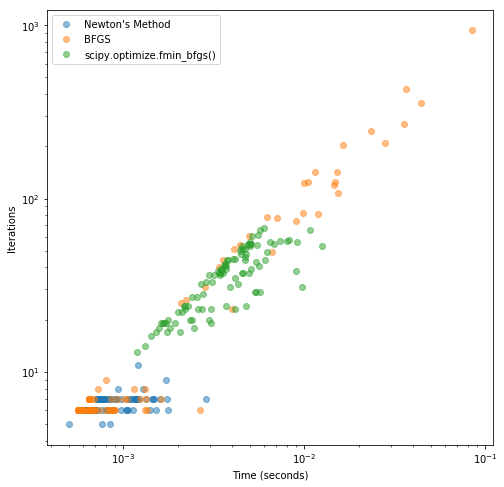

In [9]:
compare(100)

## Problem 4: The Gauss-Newton Method

In [10]:
def gauss_newton(r,J,x0,maxiter,tol):
    numiter = 0
    diff = 1
    isconverged = False
    
    while numiter < maxiter and diff > tol:
        rxk = r(x0)
        Jxk = J(x0)
        zk = la.solve(Jxk.T @ Jxk, Jxk.T @ rxk)
        x1 = x0 - zk
        diff = la.norm(x1-x0,np.inf)
        numiter += 1
        x0 = x1
        
    if diff < tol:
        isconverged = True
    
    return x1,numiter,isconverged

In [11]:
# Generate random data for t = 0, 1, ..., 10.
T = np.arange(10)
y = 3*np.sin(0.5*T)+ 0.5*np.random.randn(10) # Perturbed data.

# Define the model function and the residual (based on the data).
model = lambda x, t: x[0]*np.sin(x[1]*t) # phi(x,t)
residual = lambda x: model(x, T) - y # r(x) = phi(x,t) - y

# Define the Jacobian of the residual function, computed by hand.
jac = lambda x: np.column_stack((np.sin(x[1]*T), x[0]*T*np.cos(x[1]*T)))

In [12]:
x0 = np.array([2.5,.6])
gauss_newton(residual,jac,x0,maxiter=1e4,tol=1e-6)

(array([3.13140049, 0.47507555]), 8, True)

In [13]:
opt.leastsq(func=residual, x0=np.array([2.5,.6]), Dfun=jac)

(array([3.13139955, 0.47507582]), 1)

## Problem 5: Application of Non-linear Least Squares

In [14]:
pop = np.load('population.npy')
y = pop[:,1]
T = pop[:,0]

In [15]:
model_exp = lambda x, t: x[0]*np.exp(x[1]*(t+x[2]))
residual_exp = lambda x: model_exp(x,T) - y
jac_exp = lambda x: np.column_stack((np.exp(x[1]*(T+x[2])),
                                     x[0]*(T+x[2])*np.exp(x[1]*(T+x[2])),
                                     x[0]*x[1]*np.exp(x[1]*(T+x[2]))))

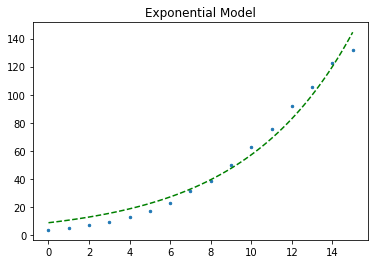

In [16]:
x_exp = opt.leastsq(func=residual_exp, x0=np.array([1.5,.4,2.5]), Dfun=jac_exp)[0]
Tdom = np.linspace(0,15,100)
yfit_exp = model_exp(x_exp,Tdom)

# plot the resulting curve along with the actual data points
plt.scatter(T, y, label='Data', s=6, marker='o')
plt.plot(Tdom, yfit_exp, 'g--', label='Normal Equations')
plt.title("Exponential Model")
plt.show()

In [17]:
model_logit = lambda x, t: x[0]/(1+np.exp(-x[1]*(t+x[2])))
residual_logit = lambda x: model_logit(x,T) - y
jac_logit = lambda x: np.column_stack((1/(1+np.exp(-x[1]*(T+x[2]))),
                                     x[0]*np.exp(-x[1]*(T+x[2]))*(T+x[2])/(1+np.exp(-x[1]*(T+x[2])))**2,
                                     x[0]*np.exp(-x[1]*(T+x[2]))*x[1]/(1+np.exp(-x[1]*(T+x[2])))**2))

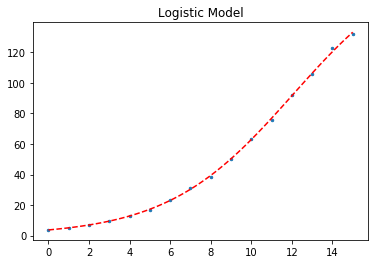

In [18]:
x_logit = opt.leastsq(func=residual_logit, x0=np.array([150,.4,-15]), Dfun=jac_logit)[0]
yfit_logit = model_logit(x_logit,Tdom)

# plot the resulting curve along with the actual data points
plt.scatter(T, y, label='Data', s=6, marker='o')
plt.plot(Tdom, yfit_logit, 'r--', label='Normal Equations')
plt.title("Logistic Model")
plt.show()